## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝알고리즘 이해 및 활용
- 평가일 : 03.10
- 성명 : 이재우
- 점수 : 87.5

Q1. iris data를 불러와서 아래 사항을 수행하세요.(15점)

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요.

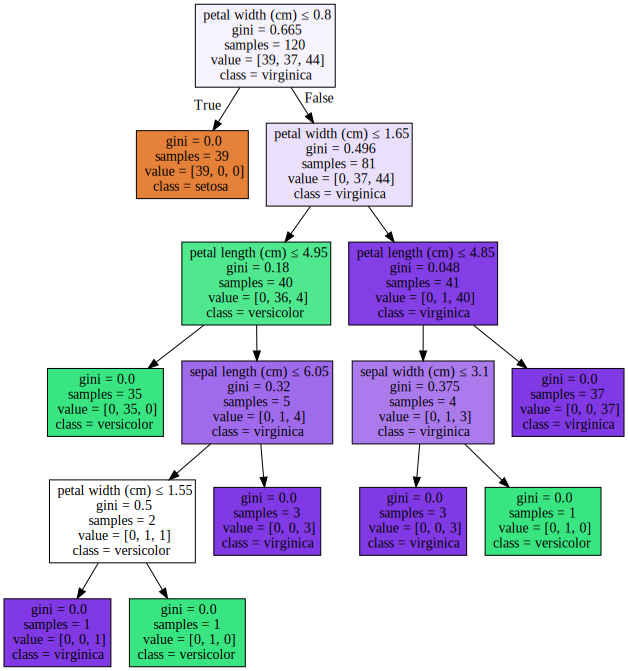

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import graphviz
from sklearn import tree

iris = load_iris()
dt_clf = DecisionTreeClassifier()
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,test_size = 0.2,random_state=1)
dt_clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(dt_clf,
                               out_file = None,
                               feature_names = iris.feature_names,
                               class_names = iris.target_names,
                               filled = True,
                               special_characters = True)
graphviz.Source(dot_data)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요(10점)
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [112]:
# Q2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, confusion_matrix,f1_score,roc_auc_score

lr = LogisticRegression(solver='liblinear')
card_df = pd.read_csv('./dataset/creditcard.csv')

def make_new_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace = True)
    return df_copy

def get_dataset(df=None):
    df = make_new_df(df)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=2)
    lr.fit(X_train,y_train)
    lr_preds = lr.predict(X_test)
    lr_preds_proba = lr.predict_proba(X_test)[:,1]
    return y_test,lr_preds,lr_preds_proba

def get_clf_evals(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print('오차행렬: \n',confusion)
    print('정확도: ',accuracy)
    print('정밀도: ',precision)
    print('재현율: ',recall)
    print('f1 score: ',f1)
    print('roc_auc: ',roc_auc)
    
y_test,lr_preds,lr_preds_proba = get_dataset(card_df)
get_clf_evals(y_test,lr_preds,lr_preds_proba)

오차행렬: 
 [[85297    12]
 [   46    88]]
정확도:  0.9993211848834895
정밀도:  0.88
재현율:  0.6567164179104478
f1 score:  0.7521367521367521
roc_auc:  0.9860297149799421


In [18]:
# Q3
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)

def get_lgbm_dataset(df=None):
    df = make_new_df(df)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=2)
    lgbm_clf.fit(X_train,y_train)
    lgbm_preds = lgbm_clf.predict(X_test)
    lgbm_preds_proba = lgbm_clf.predict_proba(X_test)[:,1]
    return y_test,lgbm_preds,lgbm_preds_proba

y_test,lgbm_preds,lgbm_preds_proba=get_lgbm_dataset(card_df)
get_clf_evals(y_test,lgbm_preds,lgbm_preds_proba)

오차행렬: 
 [[85301     8]
 [   23   111]]
정확도:  0.9996371850239341
정밀도:  0.9327731092436975
재현율:  0.8283582089552238
f1 score:  0.8774703557312253
roc_auc:  0.9785129668214042


In [19]:
def make_new_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    
    df_copy.drop(['Time','Amount'],axis=1,inplace = True)
    return df_copy

def get_dataset(df=None):
    df = make_new_df(df)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=2)
    lr.fit(X_train,y_train)
    lr_preds = lr.predict(X_test)
    lr_preds_proba = lr.predict_proba(X_test)[:,1]
    return y_test,lr_preds,lr_preds_proba

def get_lgbm_dataset(df=None):
    df = make_new_df(df)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=2)
    lgbm_clf.fit(X_train,y_train)
    lgbm_preds = lgbm_clf.predict(X_test)
    lgbm_preds_proba = lgbm_clf.predict_proba(X_test)[:,1]
    return y_test,lgbm_preds,lgbm_preds_proba

print('로지스틱 회귀')
y_test,lr_preds,lr_preds_proba = get_dataset(card_df)
get_clf_evals(y_test,lr_preds,lr_preds_proba)

print('LGBM')

y_test,lgbm_preds,lgbm_preds_proba=get_lgbm_dataset(card_df)
get_clf_evals(y_test,lgbm_preds,lgbm_preds_proba)

로지스틱 회귀
오차행렬: 
 [[85296    13]
 [   43    91]]
정확도:  0.9993445923013002
정밀도:  0.875
재현율:  0.6791044776119403
f1 score:  0.7647058823529411
roc_auc:  0.9846557807499795
LGBM
오차행렬: 
 [[85302     7]
 [   24   110]]
정확도:  0.9996371850239341
정밀도:  0.9401709401709402
재현율:  0.8208955223880597
f1 score:  0.8764940239043824
roc_auc:  0.9772458435996412


Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요(5점)
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

<AxesSubplot:>

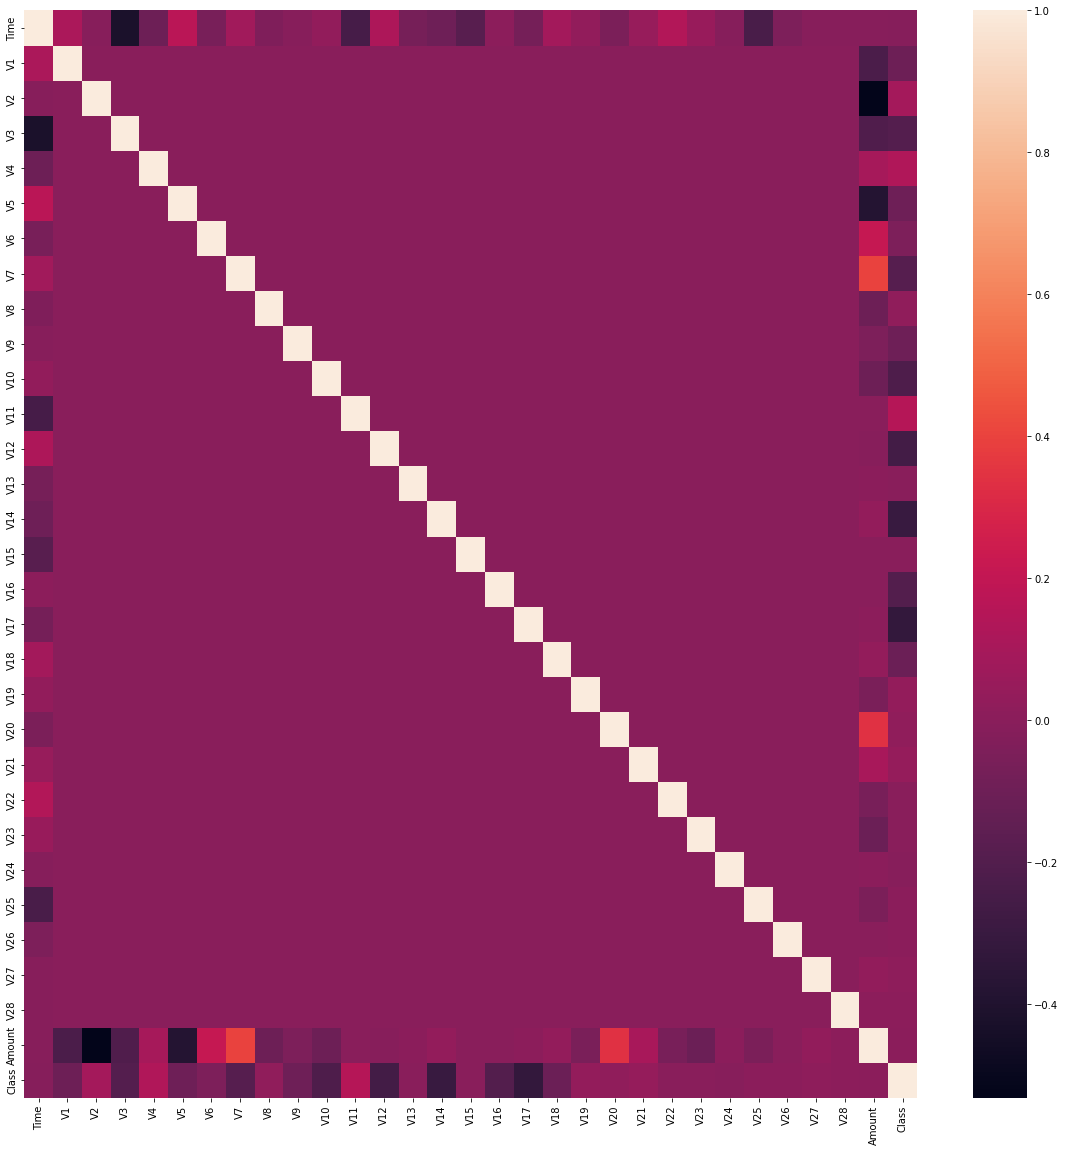

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
corr = card_df.corr()
sns.heatmap(corr)

In [21]:
# 이상치 검색
def get_outlier(df=None,column=None,weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = weight*iqr
    low_val = quantile_25-iqr_weight
    high_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud<low_val)|(fraud>high_val)].index
    return outlier_index

In [22]:
# 이상치 검출
outliers = get_outlier(df=card_df,column='V14',weight=1.5)
outliers

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [23]:
def make_new_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    
    df_copy.drop(['Time','Amount'],axis=1,inplace = True)
    
    outliers = get_outlier(df=card_df,column='V14',weight=1.5)
    df_copy.drop(outliers,axis = 0,inplace=True)
    return df_copy

print('로지스틱 회귀')
y_test,lr_preds,lr_preds_proba = get_dataset(card_df)
get_clf_evals(y_test,lr_preds,lr_preds_proba)

print('LGBM')

y_test,lgbm_preds,lgbm_preds_proba=get_lgbm_dataset(card_df)
get_clf_evals(y_test,lgbm_preds,lgbm_preds_proba)

로지스틱 회귀
오차행렬: 
 [[85278    11]
 [   48   104]]
정확도:  0.9993094650109432
정밀도:  0.9043478260869565
재현율:  0.6842105263157895
f1 score:  0.7790262172284644
roc_auc:  0.975626137386755
LGBM
오차행렬: 
 [[85284     5]
 [   29   123]]
정확도:  0.9996020645825775
정밀도:  0.9609375
재현율:  0.8092105263157895
f1 score:  0.8785714285714287
roc_auc:  0.9859118316608978


Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
def get_lgbm_dataset(df=None):
    df = make_new_df(df)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=2)
    
    X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
    
    lgbm_clf.fit(X_train_over,y_train_over)
    lgbm_preds = lgbm_clf.predict(X_test)
    lgbm_preds_proba = lgbm_clf.predict_proba(X_test)[:,1]
    return y_test,lgbm_preds,lgbm_preds_proba

print('LGBM')

y_test,lgbm_preds,lgbm_preds_proba=get_lgbm_dataset(card_df)
get_clf_evals(y_test,lgbm_preds,lgbm_preds_proba)

LGBM
오차행렬: 
 [[85277    12]
 [   24   128]]
정확도:  0.9995786566168468
정밀도:  0.9142857142857143
재현율:  0.8421052631578947
f1 score:  0.8767123287671234
roc_auc:  0.9808704583981028


Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [113]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['PRICE'] = boston.target
boston_df.to_pickle('./boston.pkl')

In [114]:
boston_df = pd.read_pickle('./boston.pkl')
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<AxesSubplot:>

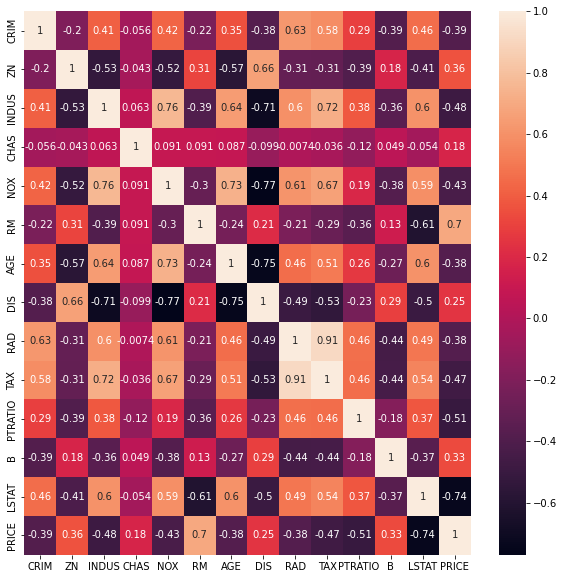

In [115]:
plt.figure(figsize = (10,10))
corr = boston_df.corr()
sns.heatmap(corr,annot=True)

In [116]:
X = boston_df[['CRIM','INDUS','NOX','RM','AGE','TAX','PTRATIO','LSTAT']]
y = np.log1p(boston_df['PRICE'])

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print('회귀계수')
print(lr.coef_)

mse = mean_squared_error(y_test,lr_preds)
rmse = np.sqrt(mse)
r_square = r2_score(y_test,lr_preds)
print('rmse ',round(rmse,4),'R2 ',round(r_square,4))

회귀계수
[-7.00685456e-03  2.27470162e-03 -2.91714643e-01  1.04907054e-01
  1.37300185e-03 -1.10727644e-04 -3.43033315e-02 -3.03346615e-02]
rmse  0.1801 R2  0.8007


Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점)
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

In [92]:
df = pd.read_pickle('./dataset/house_df.pkl')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [93]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

alphas = [0, 0.1, 1, 10, 100]
X = df.drop('PRICE',axis = 1)
y = df['PRICE']
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    neg_mse_scores = cross_val_score(ridge, X, y, scoring="neg_mean_squared_error", cv=5)
    rmse = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse)
    print('alpha: ',alpha, '평균 rmse:',avg_rmse)

alpha:  0 평균 rmse: 5.82865894621579
alpha:  0.1 평균 rmse: 5.7884866270323965
alpha:  1 평균 rmse: 5.652570965613533
alpha:  10 평균 rmse: 5.51816628086896
alpha:  100 평균 rmse: 5.329589628472134


In [94]:
def get_linear_reg_eval(model_name,params=None, X_n=None, y_n=None, verbose = True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose:
        print('#####',model_name,'######')
    for param in params:
        if model_name == 'Ridge':
            model = Ridge(alpha = param)
        elif model_name == 'Lasso':
            model = Lasso(alpha = param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha = param)
            
        neg_mse_scores = cross_val_score(model, X_n, y_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('param: ',param,'평균 rmse: ',avg_rmse)

lasso_alphas = [0.07,0.1,0.5,1,3]
get_linear_reg_eval('Lasso',params=lasso_alphas, X_n=X, y_n=y, verbose = True, return_coeff=True)
elastic_alphas = [0.07,0.1,0.5,1,3]
get_linear_reg_eval('ElasticNet',params=elastic_alphas, X_n=X, y_n=y, verbose = True, return_coeff=True)

##### Lasso ######
param:  0.07 평균 rmse:  5.612284267526676
param:  0.1 평균 rmse:  5.615116035266936
param:  0.5 평균 rmse:  5.6691234095948975
param:  1 평균 rmse:  5.776020813823376
param:  3 평균 rmse:  6.1887632108009045
##### ElasticNet ######
param:  0.07 평균 rmse:  5.5032089893304565
param:  0.1 평균 rmse:  5.4783894085720934
param:  0.5 평균 rmse:  5.412658488690828
param:  1 평균 rmse:  5.521582384760585
param:  3 평균 rmse:  5.9536085481152945


Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

In [47]:
from sklearn.svm import SVR
boston = load_boston()
X = boston.data
y = boston.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=10)
svr = SVR(kernel = 'linear',C=1.0, epsilon=0.1)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r_square = r2_score(y_test,y_pred)
print('mse ',mse,' rmse ', rmse,'R2',r_square)

mse  37.21046018112136  rmse  6.100037719647426 R2 0.6441939584708862


In [54]:
test_data = [[3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]]

y_pred = svr.predict(test_data)
y_pred

array([18.70144348])

Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

In [56]:
df = pd.read_csv('./dataset/mtcars.csv')
df.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['qsec'] = scaler.fit_transform(df[['qsec']])
len(df.loc[df['qsec']>0.5,['qsec']])

9

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 

In [121]:
df = pd.read_csv('./dataset/purdata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   object 
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
 10  gender   3500 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 300.9+ KB


In [122]:
df['환불금액'].fillna(0,inplace=True)
df

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,1,*,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,2,3197000,1639000,0.0,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,3,*,4935000,0.0,기타,광주점,18,2.444444,0.318182,16,1
4,4,29050000,24000000,0.0,보석,본 점,2,1.500000,0.000000,85,0
...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,3042900,0.0,골프,본 점,1,2.000000,1.000000,0,1
3496,3496,29628600,7200000,6049600.0,시티웨어,부산본점,8,1.625000,0.461538,40,1
3497,3497,75000,75000,0.0,주방용품,창원점,1,1.000000,0.000000,0,0
3498,3498,1875000,1000000,0.0,화장품,본 점,2,1.000000,0.000000,39,0


In [123]:
nullindex =list(df.loc[df['총구매액']=='*'].index)
df.drop(nullindex,axis = 0,inplace = True)
df['총구매액'] = df['총구매액'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3498 non-null   int64  
 1   총구매액     3498 non-null   float64
 2   최대구매액    3498 non-null   int64  
 3   환불금액     3498 non-null   float64
 4   주구매상품    3498 non-null   object 
 5   주구매지점    3498 non-null   object 
 6   내점일수     3498 non-null   int64  
 7   내점당구매건수  3498 non-null   float64
 8   주말방문비율   3498 non-null   float64
 9   구매주기     3498 non-null   int64  
 10  gender   3498 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 327.9+ KB


In [124]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['주구매상품']  = le.fit_transform(df['주구매상품'])
df['주구매지점']  = le.fit_transform(df['주구매지점'])
df.drop('cust_id',axis = 1,inplace=True)
df

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840.0,11264000,6860000.0,5,0,19,3.894737,0.527027,17,0
2,3197000.0,1639000,0.0,6,1,2,2.000000,0.000000,1,1
4,29050000.0,24000000,0.0,15,8,2,1.500000,0.000000,85,0
5,11379000.0,9552000,462000.0,11,18,3,1.666667,0.200000,42,0
6,10056000.0,7612000,4582000.0,22,0,5,2.400000,0.333333,42,0
...,...,...,...,...,...,...,...,...,...,...
3495,3175200.0,3042900,0.0,3,8,1,2.000000,1.000000,0,1
3496,29628600.0,7200000,6049600.0,22,9,8,1.625000,0.461538,40,1
3497,75000.0,75000,0.0,32,21,1,1.000000,0.000000,0,0
3498,1875000.0,1000000,0.0,41,8,2,1.000000,0.000000,39,0


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()

X = df.drop('gender',axis = 1)
y = df['gender']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 3)

dt.fit(X_train,y_train)
dt_pred_proba = dt.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,dt_pred_proba)
print(round(roc,4))

rf .fit(X_train,y_train)
rf_pred_proba = rf.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,rf_pred_proba)
print(round(roc,4))

lr.fit(X_train,y_train)
lr_pred_proba = lr.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,lr_pred_proba)
print(round(roc,4))

0.5352
0.6288
0.6486
